<a href="https://colab.research.google.com/github/GabrielYYM/Notebooks/blob/main/AtividadeFinalSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descrição do Dataset

O presente dataset representa o perfil de microbiota intestinal de crianças com e sem Transtorno do Espectro Autista (ASD). Ele foi construído a partir de sequenciamento de 16S rRNA, gerando uma matriz de abundância categorizada de microrganismos.

    Amostras: 61 crianças

        Grupo A → Crianças com ASD (Autistic Spectrum Disorder)

        Grupo B → Crianças com desenvolvimento típico (TD – Typically Developing)

    Variáveis: 5619 microrganismos identificados em nível taxonômico (gênero e espécie), com nomes no formato padrão:

        Exemplo: g__Faecalibacterium;s__Faecalibacterium prausnitzii

    Natureza dos dados:

        Cada célula da matriz indica a categoria de abundância relativa de um microrganismo em uma amostra.

        Os valores são representados qualitativamente como low (baixa abundância), mid (abundância intermediária), high (alta abundância), além de casos específicos de absent (ausente) e present (presente).

Assim, o dataset reflete a composição microbiana intestinal de cada criança, permitindo investigar se há padrões que distinguem crianças com ASD das crianças com desenvolvimento típico.


🧩 Hipótese

A composição da microbiota intestinal difere significativamente entre crianças com Transtorno do Espectro Autista (ASD) e com desenvolvimento típico (TD), e tais diferenças podem ser detectadas e exploradas por métodos de aprendizado de máquina, como SVM, para discriminar os grupos com base no perfil microbiano.
❓ Questão norteadora

É possível identificar padrões na microbiota intestinal que discriminem crianças com ASD de crianças com desenvolvimento típico (TD) utilizando algoritmos de aprendizado de máquina, e como os diferentes métodos de busca de hiperparâmetros (GridSearchCV e RandomizedSearchCV) influenciam a performance dessa classificação?


📌 Atividade

    Exploração do Dataset

        Leia e descreva a composição do dataset (amostras, grupos e variáveis).

        Reflita sobre o que significa cada categoria de abundância (low, mid, high, absent, present).

    Experimento com GridSearchCV

        Utilize o método GridSearchCV, que faz uma busca exaustiva em todas as combinações de parâmetros.
        Reduzir o número de variáveis (Use.: k=500 ou k=100 com SelectKBest).

        Observe quais parâmetros foram escolhidos como ótimos e qual foi o desempenho do modelo (acurácia, sensibilidade, especificidade, ROC-AUC).

        Reflita: quais são as vantagens de testar todas as combinações possíveis? Quais são as limitações desse método?

    Experimento com RandomizedSearchCV

        Utilize o método RandomizedSearchCV, que faz uma busca aleatória em parte do espaço de parâmetros.

        Compare os resultados com os obtidos no GridSearchCV.

        Reflita: por que o RandomizedSearch pode encontrar resultados diferentes, às vezes melhores, às vezes piores, mesmo testando menos combinações?

    Análise crítica

        Compare os dois métodos considerando:

            Tempo de execução.

            Cobertura do espaço de parâmetros.

            Qualidade e estabilidade dos resultados.

1) São 60 amostras do intestino de crianças, divididas em 2 grupos ASD e DT com multiplas variaveis dos microorganismos encontrados no intestino, sendo seu valor representante de sua abundância.  

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import time

file_path = "ASD_meta_abundance_discretized.csv"
df = pd.read_csv(file_path)
RANDOM_STATE = 42


Melhores parâmetros: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

Acurácia: 0.9166666666666666
Matriz de confusão:
 [[5 1]
 [0 6]]

Relatório de classificação:
               precision    recall  f1-score   support

          TD       1.00      0.83      0.91         6
         ASD       0.86      1.00      0.92         6

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12

ROC-AUC: 0.9722222222222223


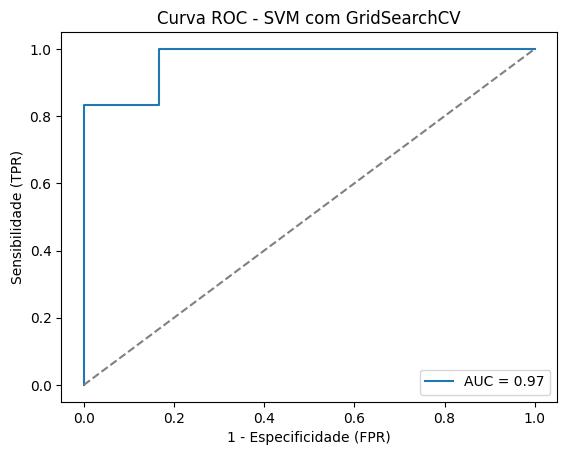

In [14]:
id_col = df.columns[0]
sample_ids = df[id_col].astype(str)
labels = sample_ids.str[0].map({'A': 'ASD', 'B': 'TD'})
y = labels.map({'ASD': 1, 'TD': 0}).astype(int)

X = df.drop(columns=[id_col]).copy()
mapping = {'absent': 0, 'low': 1, 'mid': 2, 'high': 3, 'present': 2}
X_num = X.replace(mapping).apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_num, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

k_features = 500
pipeline = Pipeline([
    ('var', VarianceThreshold(threshold=0.0)),
    ('select', SelectKBest(score_func=chi2, k=k_features)),
    ('scale', StandardScaler()),
    ('svc', SVC(probability=True, random_state=RANDOM_STATE))
])

param_grid = {
    'svc__kernel': ['linear', 'rbf'],
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Melhores parâmetros:", grid.best_params_)

y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['TD','ASD'])
roc_auc = roc_auc_score(y_test, y_proba)

print("\nAcurácia:", acc)
print("Matriz de confusão:\n", cm)
print("\nRelatório de classificação:\n", report)
print("ROC-AUC:", roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("1 - Especificidade (FPR)")
plt.ylabel("Sensibilidade (TPR)")
plt.title("Curva ROC - SVM com GridSearchCV")
plt.legend()
plt.show()

2) Suas vantagens são a confiabilidade do resultado e a garantia de que todas as combinações sejam avaliadas. No entanto, apresenta alto custo operacional e limitações de escalabilidade.

Melhores parâmetros (RandomizedSearchCV): {'svc__C': np.float64(0.0013289448722869186), 'svc__gamma': 'auto', 'svc__kernel': 'linear'}
Tempo de execução (RandomizedSearchCV): 2.4223928451538086

Acurácia: 0.9166666666666666
Matriz de confusão:
 [[5 1]
 [0 6]]

Relatório de classificação:
               precision    recall  f1-score   support

          TD       1.00      0.83      0.91         6
         ASD       0.86      1.00      0.92         6

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12

ROC-AUC: 0.9722222222222223


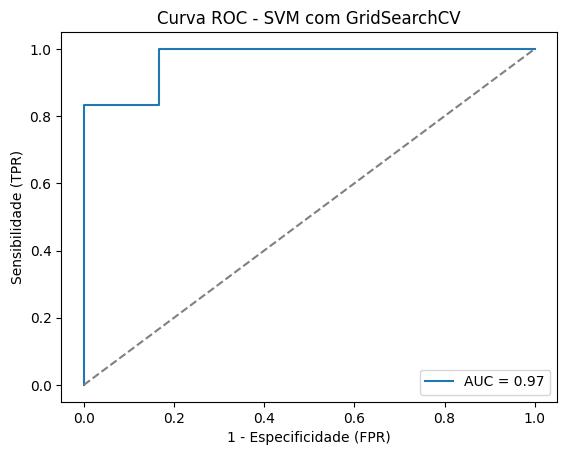

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform

param_dist = {
    'svc__kernel': ['rbf', 'linear'],
    'svc__C': loguniform(0.001, 1000),
    'svc__gamma': ['scale', 'auto']
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=100,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

start_time_rand = time.time()
random_search.fit(X_train, y_train)
end_time_rand = time.time()

print("Melhores parâmetros (RandomizedSearchCV):", random_search.best_params_)
print("Tempo de execução (RandomizedSearchCV):", end_time_rand - start_time_rand)

y_pred_rand = random_search.predict(X_test)
y_proba_rand = random_search.predict_proba(X_test)[:, 1]

acc_rand = accuracy_score(y_test, y_pred_rand)
cm_rand = confusion_matrix(y_test, y_pred_rand)
report_rand = classification_report(y_test, y_pred_rand, target_names=['TD','ASD'])
roc_auc_rand = roc_auc_score(y_test, y_proba_rand)

print("\nAcurácia:", acc)
print("Matriz de confusão:\n", cm)
print("\nRelatório de classificação:\n", report)
print("ROC-AUC:", roc_auc)

fpr_rand, tpr_rand, thresholds_rand = roc_curve(y_test, y_proba_rand)
plt.plot(fpr_rand, tpr_rand, label=f"AUC = {roc_auc_rand:.2f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("1 - Especificidade (FPR)")
plt.ylabel("Sensibilidade (TPR)")
plt.title("Curva ROC - SVM com GridSearchCV")
plt.legend()
plt.show()

3) por conta de selecionar suas combinações de forma aleatoria, não explorando todas combinações possiveis de hiperparametros.

4) GridSearch tem o tempo de execussão muito maior comparado ao randomized por conta de testar todas a combinações possiveis porem fornecendo uma cobertura completa de paremetros definidos pela grade tendo cada combinação possivel avaliada enquanto randomized oferece uma cobertura aleatoria do espaço, em questão de qualidade e estabilidade o remdomizedSearch demonstra menor estabilidade, porem com uma flutuação minima de 0.001.  